In [4]:
# MAIN IMPORTS 
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
from torchviz import make_dot
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import os

from skimage import transform as sktf
from skimage.util import random_noise
import random

# https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html - documetnation on how to make a pytorch model

In [5]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.optim import lr_scheduler

In [6]:
#data loader
# the images are loaded as float32 and normalised
# the mask is thresholded at 0.5 
""" the permute is needed since the format for image tensors must be (C, H, W)
But when we read from opencv the shape is (H, W, C)
and the mask must be of dim (1, H, W) since single channel - unsqueeze add this channel
"""
# returned as tensors 

class PuzzleDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, num_transforms=0,include_inverse_mask=True):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.num_transforms = num_transforms
        self.include_inverse_mask=include_inverse_mask
        images = sorted(os.listdir(img_dir))
        masks = sorted(os.listdir(mask_dir))
        self.data = []

        for i in range(len(images)):
            img_path = os.path.join(self.img_dir, images[i])
            mask_path = os.path.join(self.mask_dir, masks[i])

          
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (512, 512))
            image = image.astype(np.float32)/255.0
            # image = Image.fromarray(image)  

            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512,512))
            mask = (mask > 0.5).astype(np.float32) 
            # mask = Image.fromarray(mask)  #   PIL image needed for transforms

            # store the original image and mask
            self.append_image_mask(image, mask)

            # do transformations 
            for _ in range(self.num_transforms):
                transformed_image, transformed_mask = self.apply_transform(image, mask)
                self.append_image_mask(transformed_image, transformed_mask)

    def apply_transform(self, image, mask):
        """Apply deterministic transformations to both image and mask
        This is imortant since using the torchvision.transforms was givin a random transform
        for both image and mask -> they didn't match up"""
        if self.transform:
            
            if random.random() > 0.5:
                image = np.fliplr(image)
                mask = np.fliplr(mask)

           
            if random.random() > 0.5:
                image = np.flipud(image)
                mask = np.flipud(mask)

            # Apply rotation deterministically
            angle = np.random.uniform(-30, 30)
            image = sktf.rotate(image, angle, mode="edge" , preserve_range=True)
            mask = sktf.rotate(mask, angle, mode="edge" , preserve_range=True)

        return image, mask

    def append_image_mask(self, image, mask):
        """need to store them as tensors."""
        image = torch.tensor(image.transpose((2, 0, 1)), dtype=torch.float32) # (C, H, W)
        mask = torch.tensor(mask[None, ...], dtype=torch.float32)   # (1, H, W)

       
        if(self.include_inverse_mask):
            inverse_mask = 1 - mask
            combined_mask = torch.cat([inverse_mask, mask], dim=0)  # Combined (2, H, W)

        
            self.data.append((image, combined_mask))
        else:
            self.data.append((image,mask))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Loading the datasets

In [7]:
train_dataset = PuzzleDataset(
    img_dir="./images-1024x768/train/",
    mask_dir="./masks-1024x768/train/", 
    transform=True,
    num_transforms=3,
    include_inverse_mask=False 
)
val_dataset = PuzzleDataset(
    img_dir="./images-1024x768/val/",
    mask_dir="./masks-1024x768/val/",
    include_inverse_mask=False
)

test_dataset = PuzzleDataset(
    img_dir = "./images-1024x768/test/",
    mask_dir = "./masks-1024x768/test/",
    include_inverse_mask=False

)

train_dataloader = DataLoader(train_dataset,batch_size=5,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=5,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

# base class definition for unet from the library - Unet+

In [8]:
EPOCHS = 50
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

class UnetPlus(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        #print("batch:",batch[0].shape)
        image, mask = batch
        #image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        #mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        #print(f"Logits mask shape: {logits_mask.shape}, Target mask shape: {mask.shape}")


        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

### 1. Resnet34 Backbone

In [9]:
UnetRes = UnetPlus("Unet","resnet34",3,1)

In [10]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    UnetRes,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home-mscluster/remoosa/miniconda3/envs/research/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home-mscluster/remoosa/ComputerVisionLab/Lab3/lightning_logs/version_121649/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 24.4 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home-mscluster/remoosa/miniconda3/envs/research/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home-mscluster/remoosa/miniconda3/envs/research/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [11]:
#run validation dataset
valid_metrics = trainer.validate(UnetRes, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.9805421829223633, 'valid_dataset_iou': 0.9808216691017151}]


In [12]:
# run test dataset
test_metrics = trainer.test(UnetRes, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.
/home-mscluster/remoosa/miniconda3/envs/research/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.9858386516571045, 'test_dataset_iou': 0.9860371351242065}]


In [13]:
smp_model = UnetRes.model

commit_info = smp_model.save_pretrained(
    save_directory="saved_models/UnetRes",
)

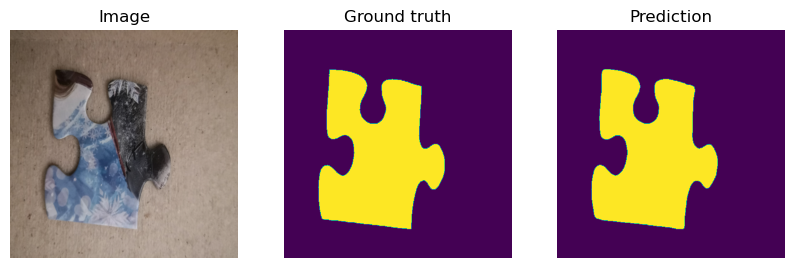

In [15]:
# Display and compare with Ground truth
batch = next(iter(test_dataloader))
with torch.no_grad():
    UnetRes.eval()
    logits = UnetRes(batch[0])
pr_masks = logits.sigmoid() >0.5
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch[0], batch[1], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

### 2. VGG backbone for Unet+

In [16]:
UnetVGG = UnetPlus("Unet","vgg11",3,1)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /home-mscluster/remoosa/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [00:08<00:00, 60.4MB/s] 


In [17]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    UnetVGG,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 18.3 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
18.3 M    Trainable params
0         Non-trainable params
18.3 M    Total params
73.016    Total estimated model params size (MB)
107       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [18]:
#run validation dataset
valid_metrics = trainer.validate(UnetVGG, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.9804311990737915, 'valid_dataset_iou': 0.980619490146637}]


In [19]:
# run test dataset
test_metrics = trainer.test(UnetVGG, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.9742059707641602, 'test_dataset_iou': 0.9743430614471436}]


In [20]:
#Save model
smp_model = UnetVGG.model

commit_info = smp_model.save_pretrained(
    save_directory="./vgg/vgg11",
)

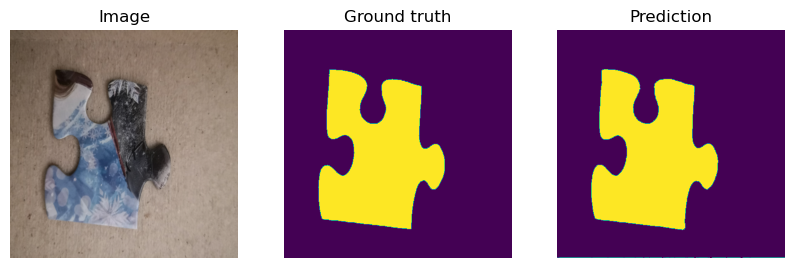

In [21]:
# Display and compare with Ground truth
batch = next(iter(test_dataloader))
with torch.no_grad():
    UnetVGG.eval()
    logits = UnetVGG(batch[0])
pr_masks = logits.sigmoid()>0.5
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch[0], batch[1], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

### 3.  EfficientNet backbone

In [30]:
import gc
# del UnetRes
# del UnetVGG
gc.collect()
UnetEff = UnetPlus("Unet","mobileone_s2",3,1)

Downloading: "https://docs-assets.developer.apple.com/ml-research/datasets/mobileone/mobileone_s2_unfused.pth.tar" to /home-mscluster/remoosa/.cache/torch/hub/checkpoints/mobileone_s2_unfused.pth.tar

  0%|          | 0.00/30.6M [00:00<?, ?B/s]
  0%|          | 128k/30.6M [00:00<03:53, 137kB/s]
  1%|          | 256k/30.6M [00:01<02:22, 224kB/s]
  1%|          | 384k/30.6M [00:01<01:31, 348kB/s]
  2%|▏         | 512k/30.6M [00:01<01:13, 431kB/s]
  2%|▏         | 768k/30.6M [00:01<00:42, 739kB/s]
  3%|▎         | 896k/30.6M [00:01<00:43, 723kB/s]
  5%|▍         | 1.50M/30.6M [00:02<00:18, 1.67MB/s]
  6%|▌         | 1.75M/30.6M [00:02<00:19, 1.58MB/s]
  9%|▉         | 2.88M/30.6M [00:02<00:08, 3.34MB/s]
 11%|█         | 3.38M/30.6M [00:02<00:09, 3.14MB/s]
 18%|█▊        | 5.38M/30.6M [00:02<00:04, 6.29MB/s]
 22%|██▏       | 6.62M/30.6M [00:02<00:03, 6.48MB/s]
 29%|██▉       | 8.88M/30.6M [00:03<00:02, 9.31MB/s]
 34%|███▍      | 10.5M/30.6M [00:03<00:02, 9.12MB/s]
 42%|████▏     | 12.8M/30

In [31]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    UnetEff,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 13.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
13.6 M    Trainable params
0         Non-trainable params
13.6 M    Total params
54.308    Total estimated model params size (MB)
481       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [32]:
#run validation dataset
valid_metrics = trainer.validate(UnetEff, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.9778842329978943, 'valid_dataset_iou': 0.9777702689170837}]


In [34]:
# run test dataset
test_metrics = trainer.test(UnetEff, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.9807623624801636, 'test_dataset_iou': 0.9807231426239014}]


In [35]:
#Save model
smp_model = UnetEff.model

commit_info = smp_model.save_pretrained(
    save_directory="./eff/efficient",
)

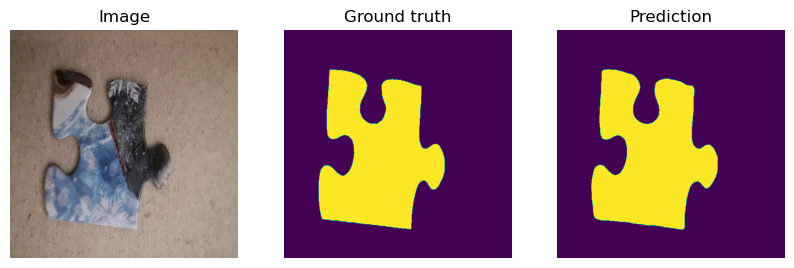

In [36]:
# Display and compare with Ground truth
batch = next(iter(test_dataloader))
with torch.no_grad():
    UnetEff.eval()
    logits = UnetEff(batch[0])
pr_masks = logits.sigmoid()>0.5
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch[0], batch[1], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break